In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import tensorflow as tf
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

In [ ]:
pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.2 MB/s eta 0:00:00


In [ ]:
from mtcnn.mtcnn import MTCNN

In [54]:
images=os.path.join(os.getcwd(),'/content/sample_data/images')
annotations=os.path.join(os.getcwd(),'/content/sample_data/annotations')
train=pd.read_csv(os.path.join(os.getcwd(),'/content/sample_data/.ipynb_checkpoints/dataset/train.csv'))
submission=pd.read_csv(os.path.join(os.getcwd(),'/content/sample_data/submission/submission.csv'))

In [55]:
print(len(train))
train.head()


15412


,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [56]:
len(submission)

8142

In [57]:
len(os.listdir(images))

265

In [58]:
a=os.listdir(images)
b=os.listdir(annotations)
a.sort()
b.sort()
print(len(b),len(a))

271 265


In [66]:
train_images=a[126:]
test_images=a[:126]

In [67]:
test_images[0]

'0001.jpg'

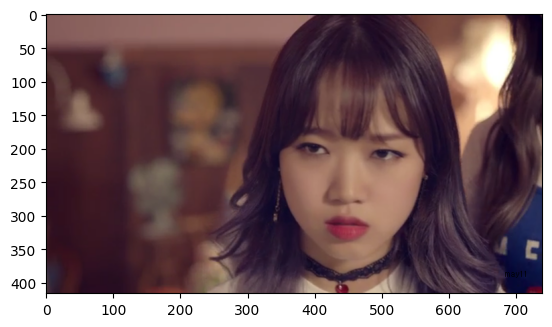

In [68]:
img=plt.imread(os.path.join(images,test_images[1]))
plt.imshow(img)
plt.show()

In [69]:
print(len(train_images))
print(len(test_images))

139
126


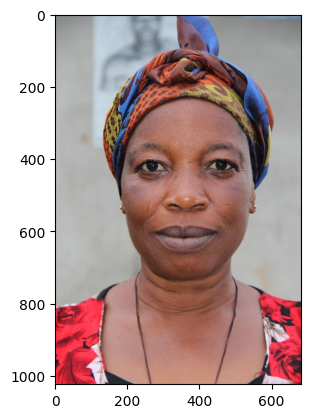

In [70]:
img=plt.imread(os.path.join(images,train_images[3]))
plt.imshow(img)
plt.show()

In [71]:
options=['face_with_mask','face_no_mask']
train= train[train['classname'].isin(options)]
train.sort_values('name',axis=0,inplace=True)

[]


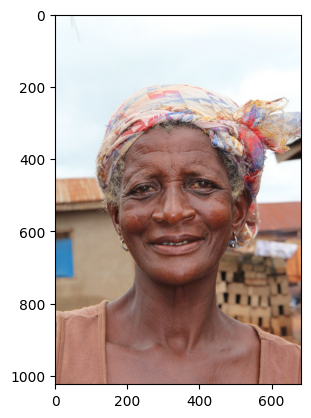

In [73]:
bbox=[]
for i in range(len(train)):
    arr=[]
    for j in train.iloc[i][["x1",'x2','y1','y2']]:
        arr.append(j)
    bbox.append(arr)
train["bbox"]=bbox
def get_boxes(id):
    boxes=[]
    for i in train[train["name"]==str(id)]["bbox"]:
        boxes.append(i)
    return boxes
print(get_boxes(train_images[2]))
image=train_images[2]

img=plt.imread(os.path.join(images,image))

fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

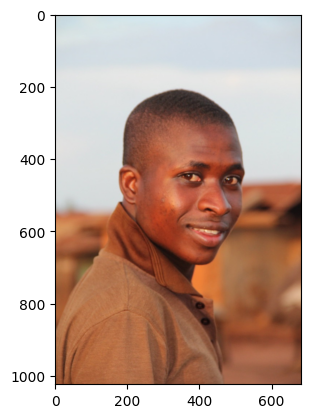

In [74]:
image=train_images[5]

img=plt.imread(os.path.join(images,image))

fig,ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

<BarContainer object of 2 artists>

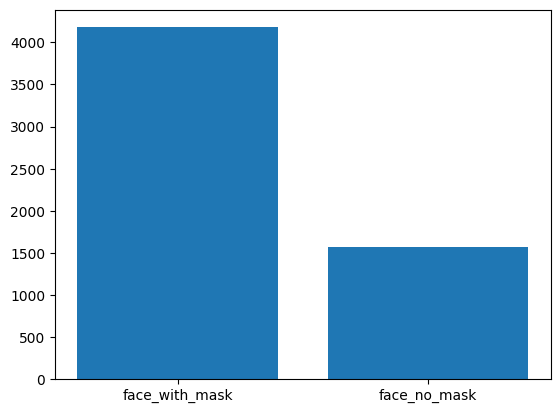

In [75]:
plt.bar(['face_with_mask','face_no_mask'],train.classname.value_counts())

In [76]:
img_size = 50
data = []

def create_data():
    for i in range(len(train)):
        arr = []
        for j in train.iloc[i]:
            arr.append(j)

        img_array = cv2.imread(os.path.join(images, arr[0]), cv2.IMREAD_GRAYSCALE)

        # Ensure image exists
        if img_array is not None:
            crop_image = img_array[arr[2]:arr[4], arr[1]:arr[3]]
            new_img_array = cv2.resize(crop_image, (img_size, img_size))
            data.append([new_img_array, arr[5]])

create_data()

# Split features and labels
x = []
y = []
for features, labels in data:
    x.append(features)
    y.append(labels)

# Check if the lengths are consistent
print(f'Length of x: {len(x)}')
print(f'Length of y: {len(y)}')

# Proceed with reshaping and encoding
x = np.array(x).reshape(-1, img_size, img_size, 1)
x = tf.keras.utils.normalize(x, axis=1)

Length of x: 0
Length of y: 0


In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
# Encode labels
lbl = LabelEncoder()
y = lbl.fit_transform(y)
y = to_categorical(y)

# Check shapes of x and y again
print(f'Shape of x: {x.shape}')
print(f'Shape of y: {y.shape}')

ValueError: zero-size array to reduction operation maximum which has no identity

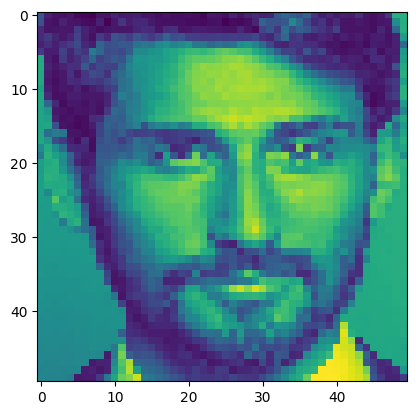

In [ ]:
data[0][0]
plt.imshow(data[0][0])

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

from keras.layers import LSTM
model=Sequential()
model.add(Conv2D(100,(3,3),activation='relu',strides=2))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
# Train-test split
opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# Fit the model
history = model.fit(X_train, y_train, epochs=25, batch_size=5, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


NameError: name 'model' is not defined

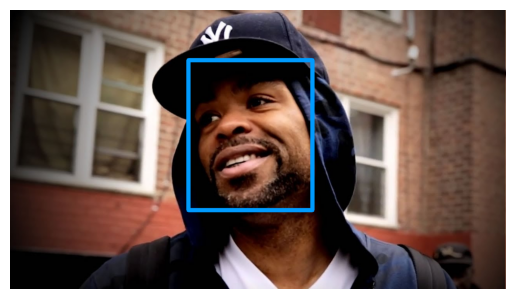

In [ ]:
import cv2
from matplotlib import pyplot as plt
from mtcnn import MTCNN
import numpy as np
import os

detector = MTCNN()

# Load the image
img = plt.imread(os.path.join(images, test_images[0]))

# Detect faces
faces = detector.detect_faces(img)

# Make a writable copy of the image
img_copy = np.copy(img)

# Draw rectangles around detected faces
for face in faces:
    bounding_box = face['box']
    x = cv2.rectangle(img_copy,(bounding_box[0], bounding_box[1]),
                      (bounding_box[0] + bounding_box[2], bounding_box[1] + bounding_box[3]),
                      (0, 155, 255),
                      10)

# Display the image with the rectangle(s)
plt.imshow(img_copy)
plt.axis('off')  # Hide axes for a cleaner display
plt.show()

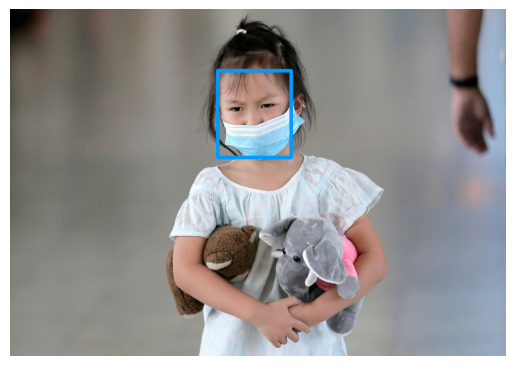

In [ ]:
# Load the image
img = plt.imread(os.path.join(images, test_images[3]))

# Detect faces
faces = detector.detect_faces(img)

# Make a writable copy of the image
img_copy = np.copy(img)

# Draw rectangles around detected faces
for face in faces:
    bounding_box = face['box']
    x = cv2.rectangle(img_copy,
                      (bounding_box[0], bounding_box[1]),
                      (bounding_box[0] + bounding_box[2], bounding_box[1] + bounding_box[3]),(0, 155, 255), 10)

# Display the image with the rectangle(s)
plt.imshow(img_copy)
plt.axis('off')  # Hide axes for a cleaner display
plt.show()

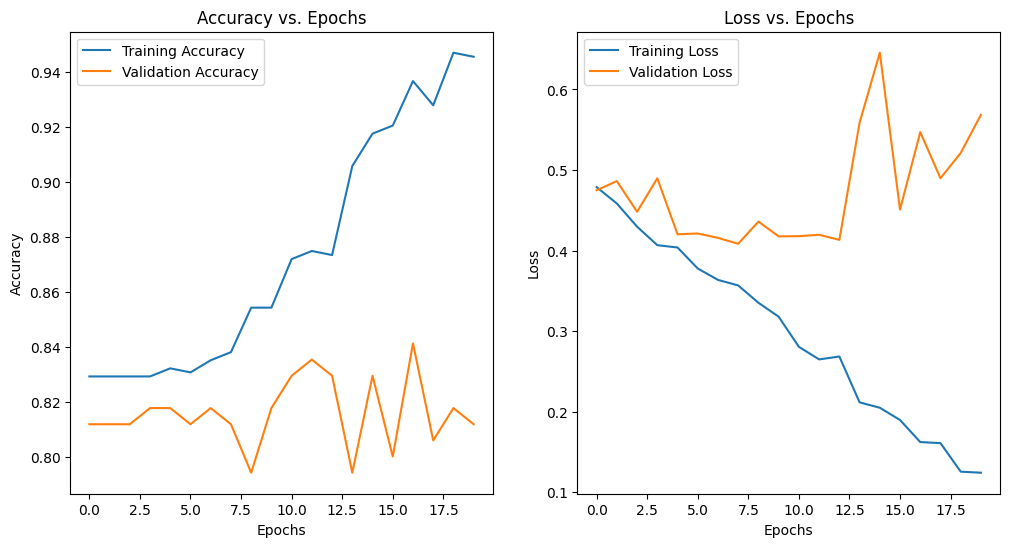

In [ ]:
# Plot Accuracy vs. Loss Curves
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

plt.show()

In [ ]:
# Classification Report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=['face_with_mask', 'face_no_mask']))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
Classification Report:
                 precision    recall  f1-score   support

face_with_mask       0.50      0.19      0.27        32
  face_no_mask       0.84      0.96      0.89       138

      accuracy                           0.81       170
     macro avg       0.67      0.57      0.58       170
  weighted avg       0.77      0.81      0.78       170



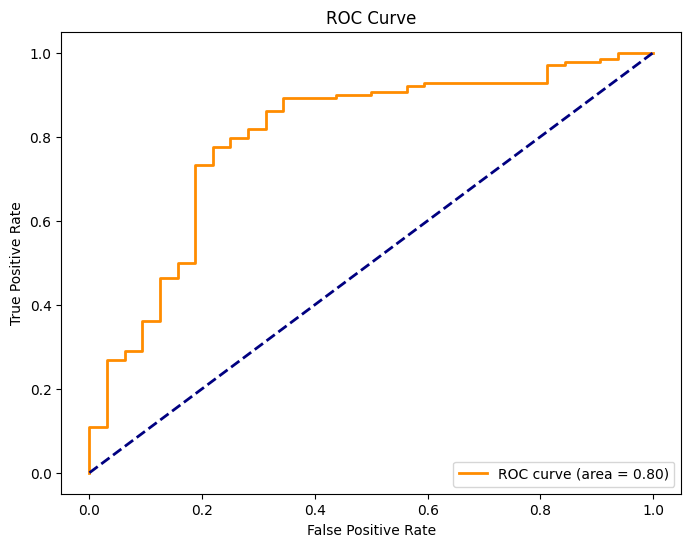

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred[:, 1])  # Use probabilities for class 1 (face_no_mask)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()